In [1]:
import numpy as np
import pandas as pd 
import os
from pandas import read_csv
from datetime import datetime
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import nanmean
import statistics 
import math
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [0]:
df = pd.read_csv("/content/pollution.csv",index_col=0)

In [15]:
df.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [16]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [17]:
df.shape

(43800, 8)

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together

    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
def model(data,y):
    data=data.dropna(axis=0, subset=[y])# y = "pm2.5"
    #Removing maximum Nan value columns 
    col=data.columns
    g=[]
    for j in range(data.shape[1]):
        if((data.iloc[:,j].isnull().sum())>=(data.shape[1]/2)):
            g.append(col[j])        
    data = data.drop(g,1)
    
    #mean and mode 
    
    col=data.columns
    
    for i in range(data.shape[1]):
        if((str(data.iloc[:,i].dtypes) == 'int64') or (str(data.iloc[:,i].dtypes) == 'float64')):
            t=nanmean(data[col[i]])
            data.loc[data[col[i]].isnull()==True,[col[i]]]=t
        else:
            t=statistics.mode(data[col[i]])
            data.loc[data[col[i]].isnull()==True,[col[i]]]=t
            
    
    data = pd.get_dummies(data)
    
    scaler=StandardScaler()
    data = data.select_dtypes(include=np.number)
    cols = data.columns
    data=scaler.fit_transform(data)
    data = pd.DataFrame(data,columns=cols) 
    
    reframed = series_to_supervised(data, 1, 1)
    reframed = reframed.iloc[:,:data.shape[1]+1]
    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r_square = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print("R-square Value : ",r_square)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8760 samples, validate on 35039 samples
Epoch 1/10





 - 7s - loss: 0.5612 - val_loss: 0.4071
Epoch 2/10
 - 2s - loss: 0.2737 - val_loss: 0.1835
Epoch 3/10
 - 2s - loss: 0.1717 - val_loss: 0.1617
Epoch 4/10
 - 2s - loss: 0.1644 - val_loss: 0.1585
Epoch 5/10
 - 2s - loss: 0.1611 - val_loss: 0.1555
Epoch 6/10
 - 2s - loss: 0.1590 - val_loss: 0.1541
Epoch 7/10
 - 2s - loss: 0.1577 - val_loss: 0.1541
Epoch 8/10
 - 2s - loss: 0.1570 - val_loss: 0.1554
Epoch 9/10
 - 2s - loss: 0.1568 - val_loss: 0.1535
Epoch 10/10
 - 2s - loss: 0.1561 - val_loss: 0.1533


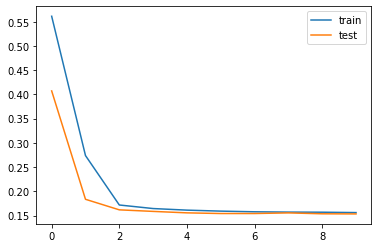

Test RMSE: 27.569
R-square Value :  0.9103705764709034


In [20]:
model(df,'pollution')